# **Correlators of various components of the color electric fields in the Glasma**

Electric fields correlators of the Glasma $\langle E(\tau_\mathrm{form})E(\tau)\rangle$, as a function of proper time $\tau$, evaluated starting from a formation time $\tau_{\mathrm{form}}$, averaged over the transverse simulation plane where the fields reside. In this example, the choice for the saturation scale $Q_s$ is suitable for a $\mathrm{Pb}\text{-}\mathrm{Pb}$ collision at LHC energy $\sqrt{s}=5.02\,\mathrm{TeV}$.

Import all the necessary modules and packages.

In [1]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
from curraun.electric_fields import ElectricFields
from curraun.electric_fields_correlators import ElectricFieldsCorrelators

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
from tqdm.notebook import tqdm

Using CUDA
Using SU(2)
Using double precision
Using double precision
Using double precision


Simulation routine for a single event, where all the parameters are stored in a dictionary.

In [2]:
# Define hbar*c [GeV*fm]
hbarc = 0.197326 

def simulate(p):    
    # Derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc
    p['E0'] = E0
    DT = 1.0 / p['DTS']
    maxt = int(p['TMAX'] / a) * p['DTS']
    formt = int(p['TFORM'] / a) * p['DTS']

    s = core.Simulation(p['N'], DT, p['G'])
    va = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
    vb = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
    initial.init(s, va, vb)

    elfields = ElectricFields(s)
    elfieldscorr = ElectricFieldsCorrelators(s)

    if use_cuda:
        s.copy_to_device()

    tau = []
    EformE_tau = []

    for t in range(maxt):
        core.evolve_leapfrog(s)

        if t==formt:  
            elfields = elfields.compute()
            Exform, Eyform, Ezform = elfields[:, 0], elfields[:, 1], elfields[:, 2]

        elif t>=formt:
            EformE = np.zeros((3,3))
            EformE[0,0], EformE[1,1], EformE[2,2] = elfieldscorr.compute(Exform, Eyform, Ezform)
            EformE[1,0], EformE[2,1], EformE[0,2] = elfieldscorr.compute(Eyform, Ezform, Exform)
            EformE[2,0], EformE[0,1], EformE[1,2] = elfieldscorr.compute(Ezform, Exform, Eyform)
            # Fields correlator units [GeV / fm^3]
            # units = E0 ** 4 / hbarc ** 3
            # Fields correlator units [GeV^2 / fm^2]
            units = (E0 ** 2 / hbarc) ** 2
            EformE *= units

            current_tau = t / p['DTS'] * a
            tau.append(current_tau)

            EformE_tau.append(EformE)

    if use_cuda:
        s.copy_to_host()
        
    return p, s, tau, EformE_tau

Parameters used in the simulation.

In [3]:
# Number of color sheets
ns = 50
# Ratio Qs/g^2\mu
factor = 0.8
# Mass number for Pb
A = 207
# Center-of-mass energy for Pb-Pb at 5.02 TeV [GeV]
sqrts = 5020
# Saturation scale [GeV]
Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)		
# Running coupling constant
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))		
# MV model parameter [GeV]
mu = Qs / (g**2 * factor)	
# Infrared regulator [GeV]
m = 0.1 * g**2 * mu   

# Formation times [GeV/fm]
taus_form = [0.06]
# Simulation time [GeV/fm]
tau_s = 0.3

# Length of simulation box [fm]
L = 15
# Number of discretization points
N = 1024
# Numerical time interval
DTS = 16
# Number of events
n_events = 20

Running the simulation for multiple events and various values of formation times.

In [4]:
for tau_form in taus_form:
    print("Formation time = {:1.2f} [GeV/fm]".format(tau_form))

    all_EformE = []

    # Standard MV model paramaters
    p = {
        # Parameters for simulation box
        'L':    L,           # transverse size [fm]
        'N':    N,            # lattice size
        'DTS':  DTS,             # time steps per transverse spacing
        'TMAX': tau_s,          # max. proper time (tau) [fm/c]
        'TFORM': tau_form,       # formation time of the HQ [fm/c]

        # Parameters for MV model
        'G':    g,            # YM coupling constant
        'MU':   mu,             # MV model parameter [GeV]
        'M':    m,              # IR regulator [GeV]
        # 'UV':   10000.0,      # UV regulator [GeV]
        'UV':   10.0, 
        'NS':   ns,             # number of color sheets
    }

    with tqdm(total=n_events, file=sys.stdout) as pbar:
        for nev in range(0, n_events):
            p, s, tau, EformE_tau = simulate(p)

            all_EformE.append(EformE_tau)

            pbar.set_description('Event {} / {}'.format(nev+1, n_events))
            pbar.update(1)

    avg_EformE, std_EformE = np.mean(all_EformE, axis = 0), np.std(all_EformE, axis = 0)

    filename = 'elfieldscorr.npz'
    np.savez(filename, avg_EformE=avg_EformE, std_EformE=std_EformE, tau=tau)

Formation time = 0.06 [GeV/fm]


  0%|          | 0/20 [00:00<?, ?it/s]

Read data from files.

In [5]:
filename = 'elfieldscorr.npz'
data = np.load(filename)
avg_EformE, std_EformE, tau = data['avg_EformE'], data['std_EformE'], data['tau']

Various commands for plotting.

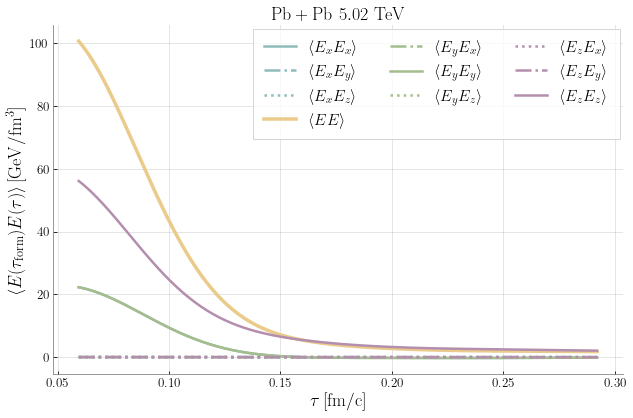

In [15]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':13})

plt.figure()
plt.title(r'$\mathrm{Pb+Pb\,\,5.02\,\,TeV}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\Big\langle E(\tau_\mathrm{form})E(\tau)\Big\rangle\,\mathrm{[GeV/fm^3]}$', size = 18)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.tick_params(direction='in', grid_color='gray', grid_alpha=0.5)
# ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
plt.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)

colors = ['#8FBCBB', '#A3BE8C', '#B48EAD', '#EBCB8B']

# a = L/N
# maxt = int(tau_s / a) * DTS
# formt = int(taus_form[0] / a) * DTS
# tau = np.linspace(taus_form[0], tau_s, maxt-formt-1)

plt.plot(tau, avg_EformE[:, 0, 0], '-', color = colors[0], markersize = 0, linewidth = 2.5, label = r'$\langle E_xE_x\rangle$', linestyle='solid')
plt.plot(tau, avg_EformE[:, 0, 1], '-', color = colors[0], markersize = 0, linewidth = 2.5, label = r'$\langle E_xE_y\rangle$', linestyle='dashdot')
plt.plot(tau, avg_EformE[:, 0, 2], '-', color = colors[0], markersize = 0, linewidth = 2.5, label = r'$\langle E_xE_z\rangle$', linestyle='dotted')
# plt.fill_between(tau, avg_corr-std_corr, avg_corr+std_corr, color = colors[i], alpha=0.2)
# plt.fill_between(tau, avg_corr, color = colors[i], alpha=0.2)
plt.plot(tau, avg_EformE[:, 0, 0]+avg_EformE[:, 1, 1]+avg_EformE[:, 2, 2], '-', color = colors[3], markersize = 0, linewidth = 3.5, label = r'$\langle EE\rangle$', linestyle='solid')

plt.plot(tau, avg_EformE[:, 1, 0], '-', color = colors[1], markersize = 0, linewidth = 2.5, label = r'$\langle E_yE_x\rangle$', linestyle='dashdot')
plt.plot(tau, avg_EformE[:, 1, 1], '-', color = colors[1], markersize = 0, linewidth = 2.5, label = r'$\langle E_yE_y\rangle$', linestyle='solid')
plt.plot(tau, avg_EformE[:, 1, 2], '-', color = colors[1], markersize = 0, linewidth = 2.5, label = r'$\langle E_yE_z\rangle$', linestyle='dotted')

plt.plot(tau, avg_EformE[:, 2, 0], '-', color = colors[2], markersize = 0, linewidth = 2.5, label = r'$\langle E_zE_x\rangle$', linestyle='dotted')
plt.plot(tau, avg_EformE[:, 2, 1], '-', color = colors[2], markersize = 0, linewidth = 2.5, label = r'$\langle E_zE_y\rangle$', linestyle='dashdot')
plt.plot(tau, avg_EformE[:, 2, 2], '-', color = colors[2], markersize = 0, linewidth = 2.5, label = r'$\langle E_zE_z\rangle$', linestyle='solid')


leg = ax.legend(fontsize = 16, loc = 'upper right', ncol=3)
leg.get_frame().set_boxstyle('square')
# leg.set_title(r'$\tau_\mathrm{form}\,\mathrm{[fm/c]}$',prop={'size':18})

plt.tight_layout()

plt.show()